In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installing dependencies

In [2]:
!pip uninstall -y tensorflow tensorflow-gpu
!pip install tensorflow==2.12.0
!pip install tensorflow-gpu==2.12
!pip list
!pip install kaggle

  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (586.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.12.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.12.0 which is incompatible.
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pi

In [3]:
import os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [4]:

print(tf.__version__)
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

2.12.0
tf.Tensor(-1705.8688, shape=(), dtype=float32)


In [ ]:
# as im getting data from kaggle i connect to the API using the kaggle.json information

In [5]:
os.environ['KAGGLE_USERNAME'] = 'rachelpilco'
os.environ['KAGGLE_KEY'] = 'db876df1af0c232d7f05330a975eda27'

In [ ]:
# downloading the datasets

In [6]:
!kaggle datasets download -d karmansinghbains/oasis-images-data
!unzip oasis-images-data.zip

Dataset URL: https://www.kaggle.com/datasets/karmansinghbains/oasis-images-data
License(s): unknown
oasis-images-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  oasis-images-data.zip
replace Data/Highly Demented/OAS2_0087_MR2_1slice_62.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
# limitng resources used by tensorflow to avoid memeory issues
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
# evening out the dataset size
# found to be a severe imbalance of {3: 4518, 1: 2664, 2: 954, 0: 66}
# reducing the number of samples for each to 200 should also help with resources usage
def balance_df(mri_data):
  iterator = mri_data.as_numpy_iterator()
  from collections import defaultdict
  import random
  import numpy as np

  max_items = 2000

  balance_img = []
  balance_label = []

  total_images = []
  total_labels = []

  classes =  {0: [], 1: [], 2: [], 3: []}

  for images,labels in mri_data:
    total_images.append(images.numpy())
    total_labels.append(labels.numpy())

  total_images = np.concatenate(total_images, axis=0)
  total_labels = np.concatenate(total_labels, axis=0)

  for i in range(len(total_labels)):
    image = total_images[i]
    label = int(total_labels[i])
    classes[label].append((image,label))

  for label in range(4):
    current = classes[label]
    current_items = current
    if len(current) > max_items:
       current_items = random.sample(current, max_items)

    for img, l in current_items:
      balance_img.append(img)
      balance_label.append(l)

  balance_img = np.array(balance_img)
  balance_label = np.array(balance_label)

  balance_ds =  tf.data.Dataset.from_tensor_slices((  balance_img ,   balance_label))
  return balance_ds


In [9]:
#  create a data pipelines(labels,img)/loaders
mri_data = tf.keras.utils.image_dataset_from_directory('/content/Data', batch_size = 64)
display(mri_data)
full_data = len(mri_data)
# iterator = mri_data.as_numpy_iterator()
all_labels = []
for _, labels in mri_data :
    all_labels.extend(labels.numpy())

unique, counts = np.unique(all_labels, return_counts=True)
print("Classes found: ", unique)
print("Counts per class:", counts)
data_classes = mri_data.class_names
mri_data = balance_df(mri_data)
mri_data = mri_data.batch(64)
# getting batches of data
# iterator = mri_data.as_numpy_iterator()
# data_batches = iterator.next()


Found 8202 files belonging to 4 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Classes found:  [0 1 2 3]
Counts per class: [  66 2664  954 4518]


In [10]:
all_labels = []
for _, labels in mri_data :
    all_labels.extend(labels.numpy())

unique, counts = np.unique(all_labels, return_counts=True)
print("Classes found:", unique)
print("Counts per class:", counts)

Classes found: [0 1 2 3]
Counts per class: [  66 2000  954 2000]


In [11]:

def calculating_weights_shape(new_ds):
  train_labels = []
  for i,labels in new_ds:
    train_labels.extend(labels.numpy())

  train_labels = np.array(train_labels )
  weights_c = compute_class_weight('balanced', classes=np.unique(train_labels), y= train_labels)
  weights_c = dict(zip(np.unique(train_labels), weights_c))

  for img, labels in new_ds.take(1):
    print(img.shape)
    print(labels.shape)
  print(weights_c)

  return weights_c
  # here we can tell there is not enough samples for the highly demented class = 0
  # {np.int32(0): np.float64(28.67543859649123), np.int32(1): np.float64(0.7728132387706855), np.int32(2): np.float64(2.1706507304116864), np.int32(3): np.float64(0.4523941323000277)}


In [12]:
def plotting_img(data_batches, data_classes):
  figure_plt, single_plt = plt.subplots(ncols=4, figsize = (20,20))
  for index, image in enumerate(data_batches[0][:4]):
    single_plt[index].imshow(image)
    # single_plt[index].title.set_text(data_batches[1][index])
    single_plt[index].title.set_text(data_classes[(data_batches[1][index])])


0.0
0.9913237


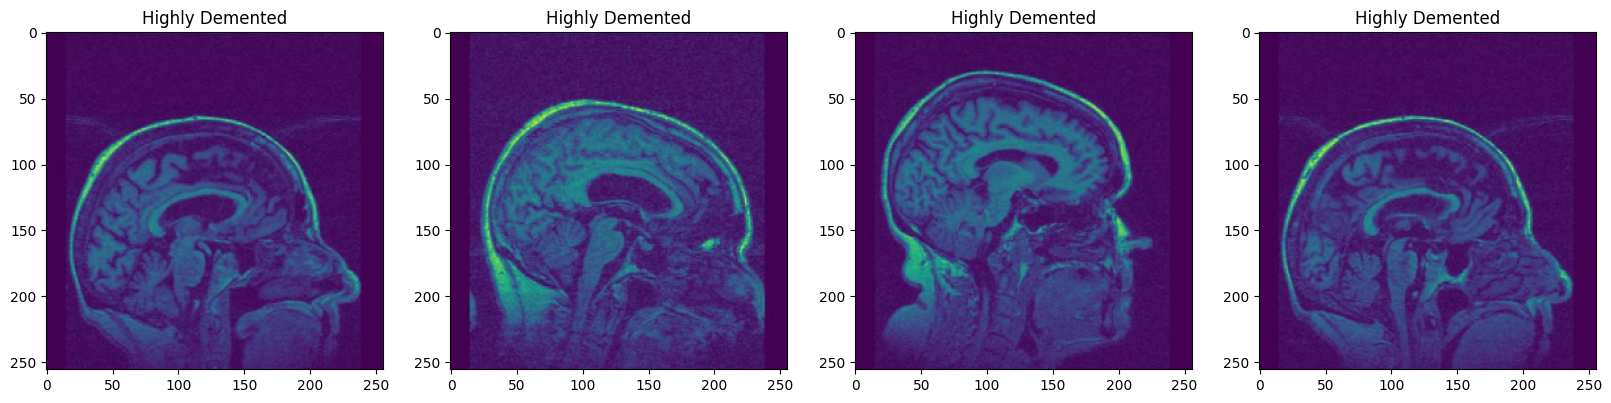

In [13]:
# cleaning the data (aka the preprocessing stage of the images)
# scaling the data to fit between values 0-1, we do this using our pipline (speeds up the accessing of the data)
mri_data = mri_data.map(lambda x, y: (tf.cast(x/255.0, tf.float32), y))
new_iterator = mri_data.as_numpy_iterator()
scaled_batch = new_iterator.next()
# scaled_data = data_batches[0]/258
img, labels = scaled_batch
print(img.min())
print(img.max())
plotting_img(scaled_batch, data_classes)
# getting the labels

In [14]:
def count_classes(data):
  all_labels = []
  for _, labels in data:
      all_labels.extend(labels.numpy() )

  unique_labels, counts = np.unique(all_labels, return_counts=True)
  print("classes:", unique_labels)
  print("class counts:", counts)
  return counts

In [15]:
count = count_classes(mri_data)

classes: [0 1 2 3]
class counts: [  66 2000  954 2000]


In [16]:
# due to normalisation issues causing a increase in loss and a decline in accuracy
# i decerned that there was not enough samples within the highly demented class/ moderately demented class

# label_dup label of interest
def create_aug_duplicates(label_dup, ds, count, total):

  train_ds = ds
  train_ds = train_ds.unbatch()
  # print("before augementation:")
  # count_classes(train_ds)
  class_dup = train_ds.filter(lambda x, y: tf.reduce_any(tf.equal(y,label_dup)))

  #  x = img, y = label
  # filtering out classes with the label 0 (highly demeneted) or 2 (moderate demented)
  rest_of_classes = train_ds.filter(lambda x, y: tf.not_equal(y,label_dup))

  dups = (total - count) // count +1

  # data augmentation
  augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomBrightness(0.4),
      tf.keras.layers.RandomRotation(0.3),
      tf.keras.layers.RandomZoom(0.4),
      tf.keras.layers.GaussianNoise(0.1),
      tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  ])
  # function applies the augemntation to each batch, creating "duplicates"
  def aug_duplicates(img, label):
    aug_imgs = []
    aug_labels = []
    # here im creating duplicates of the og images but
    # altering them with augemntation to create"new" samples
    for i in range(dups):
      aug_img = augmentation(img, training = True)
      aug_imgs.append(aug_img)
      aug_labels.append(label)
    return tf.stack(aug_imgs),tf.stack(aug_labels)

  augmented_dataset = class_dup.map(lambda x, y: aug_duplicates(x, y)).unbatch()

  new_ds = rest_of_classes.concatenate(augmented_dataset)
  new_ds = new_ds.shuffle(buffer_size = 10000).batch(64)

  return new_ds


mri_data = create_aug_duplicates(0, mri_data, counts[0], 2000)
count_classes(mri_data )
mri_data = create_aug_duplicates(2, mri_data, counts[2], 2000)
count_classes(mri_data )



# trying to get the data to all be 2000 samples

classes: [0 1 2 3]
class counts: [1980 2000  954 2000]
classes: [0 1 2 3]
class counts: [1980 2000 1908 2000]


array([1980, 2000, 1908, 2000])

In [17]:
# splitting the data into training and tesing set
# a bit different vs to splitting data in pytorch

# first getting the sizes of the full traning set and calculating the train and val
shuffled_data = mri_data.shuffle(buffer_size=50)
training_size = int(0.7 * full_data)
validation_size = int(0.2 * full_data)
test_size = int(0.1 * full_data)

# splitting the dataset
train_ds = shuffled_data.take(training_size)
val_ds = shuffled_data.skip(training_size).take(validation_size)
test_ds = shuffled_data.skip(validation_size).take(test_size)
calculating_weights_shape(train_ds)

(64, 256, 256, 3)
(64,)
{0: 0.9951219512195122, 1: 0.9916666666666667, 2: 1.0221904080171798, 3: 0.9916666666666667}


{0: 0.9951219512195122,
 1: 0.9916666666666667,
 2: 1.0221904080171798,
 3: 0.9916666666666667}

In [ ]:
# cnn

In [18]:
model = Sequential([

    Conv2D(128, (3,3), 1, activation='relu',  kernel_initializer='he_normal'),
    BatchNormalization(),
    AveragePooling2D(2, 2),

    Conv2D(256, (3,3), 1, activation='relu',  kernel_initializer='he_normal'),
    BatchNormalization(),
    AveragePooling2D(2, 2),

    Flatten(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax'),
])

In [19]:
# train

In [20]:
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_rate=0.9,decay_steps=100)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= scheduler), loss='sparse_categorical_crossentropy', metrics =['accuracy'])
# model.summary()

In [22]:
scheduler_LR = ReduceLROnPlateau(monitor = 'val_loss', factor=0.2, patience = 4, verbose=1.0)

In [23]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience = 5,
    restore_best_weights=True,
    verbose=1
)

In [24]:
log = 'logs'
call_back = tf.keras.callbacks.TensorBoard(log_dir = log)
model_history = model.fit(train_ds, epochs = 30, validation_data=val_ds, callbacks=[early_stopping])
# class_weight=weight_c


Epoch 1/30
90/90 [==============================] - 570s 6s/step - loss: 239.4571 - accuracy: 0.5205 - val_loss: 589.6106 - val_accuracy: 0.4950
Epoch 2/30
90/90 [==============================] - 557s 6s/step - loss: 111.7197 - accuracy: 0.5753 - val_loss: 314.0157 - val_accuracy: 0.2410
Epoch 3/30
90/90 [==============================] - 561s 6s/step - loss: 69.4829 - accuracy: 0.6160 - val_loss: 49.9104 - val_accuracy: 0.3525
Epoch 4/30
90/90 [==============================] - 555s 6s/step - loss: 11.7089 - accuracy: 0.6091 - val_loss: 7.3769 - val_accuracy: 0.4913
Epoch 5/30
90/90 [==============================] - 557s 6s/step - loss: 2.2971 - accuracy: 0.6350 - val_loss: 4.9009 - val_accuracy: 0.5193
Epoch 6/30
90/90 [==============================] - 558s 6s/step - loss: 1.6632 - accuracy: 0.6806 - val_loss: 1.5618 - val_accuracy: 0.6823
Epoch 7/30
90/90 [==============================] - 558s 6s/step - loss: 0.9724 - accuracy: 0.6943 - val_loss: 0.4657 - val_accuracy: 0.7152
Ep

In [ ]:
# plotting the model loss
# converted, mild demented, demented

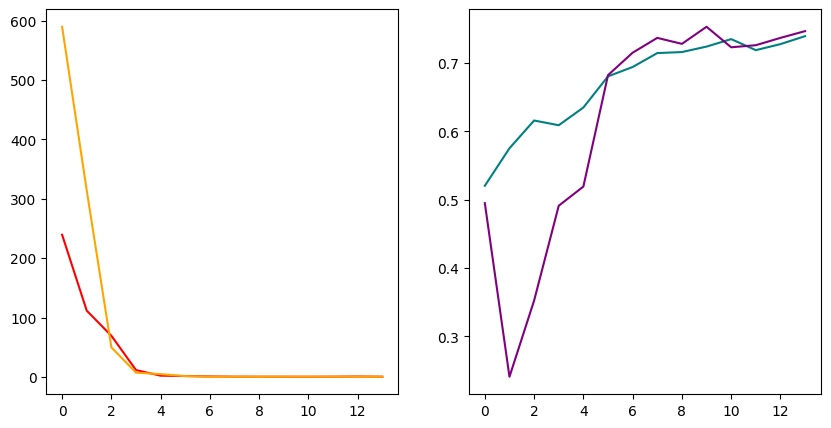

In [34]:
fig, (plt1, plt2) = plt.subplots(1,2,figsize=(10,5))
plt1.plot(model_history.history['loss'], color='red', label='train loss')
plt1.plot(model_history.history['val_loss'], color='orange', label='validation loss')
plt2.plot(model_history.history['accuracy'], color='teal', label='training accuracy')
plt2.plot(model_history.history['val_accuracy'], color='purple', label='accuracy validation')
plt.show()

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [27]:
for img in test_ds:
  input, label = img

In [28]:
loss_test, acc_test = model.evaluate(input, label)

2/2 [==============================] - 1s 622ms/step - loss: 0.3740 - accuracy: 0.7344


In [31]:
# using sklearn to get the evalation metrics (initally forgot to inclue them in the metrics in complile)
from sklearn.metrics import precision_score, recall_score, f1_score

final_predictions = model.predict(input)
final_predicted_classes = np.argmax(final_predictions, axis =1)
print(f"precision score all labels:{precision_score(label, final_predicted_classes, average= 'micro')}")
print(f"precision score per label:{precision_score(label, final_predicted_classes, average='macro')}")
print(f"recall score all labels:{recall_score(label, final_predicted_classes, average= 'micro')}")
print(f"recall score per label:{recall_score(label, final_predicted_classes, average='macro')}")
print(f"f1 score all labels:{f1_score(label, final_predicted_classes, average='micro')}")
print(f"f1 score per label:{f1_score(label, final_predicted_classes, average='macro')}")



2/2 [==============================] - 1s 626ms/step
precision score all labels:0.734375
precision score per label:0.5982142857142857
recall score all labels:0.734375
recall score per label:0.75
f1 score all labels:0.734375
f1 score per label:0.641025641025641


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
